# An example of using the calculation of the cost of the algorithm and its calculation

In [1]:
#Required packages to be installed
#pip install qiskit-optimization
#pip install cplex docplex

!pip install qiskit-optimization
!pip install cplex docplex 
!pip install qiskit-optimization[cplex]


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


imports of qubo files

In [2]:
%%capture
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from qubo import AlgoritmQAOA
#from costdc import PlatformsViewController
from ipynb.fs.full.calccost_for_different_depths import PlatformsViewController

An example of calculating the cost of an algorithm ans vary the depth

In [3]:
nodes = 4

# Energy cost for having node occupied. It is negative so it is favourable for having this occupied.
weights_nodes = [-2,-2,-2,-2,-2,-2]

# Cost for having two connected nodes occupied. This may counteract the positive benefit (weights_nodes)
# for having the nodes occupied, and leads to the complexity for the problem.
weights_edges = [1,2,2,1]


W = [[1, -2  , -2  , -2],
     [0, 2, -2 , -2],
     [0, 0  , 2, -2],
     [0, 0  , 0  , 1],
    ]

alg = []
qc =[]
for p in range(1,11):
    alg.append( AlgoritmQAOA(W, reps = p ))
    qc.append(  alg[p-1].get_circuit() ) 
    


In this simple example not so many qubits are needed, indeed 7 qubits system would suffice, but they are for free and to have an cost estimate, we use the 27 qubit system. The costs increase with higher circuit depths.

Text(0, 0.5, 'costs in $')

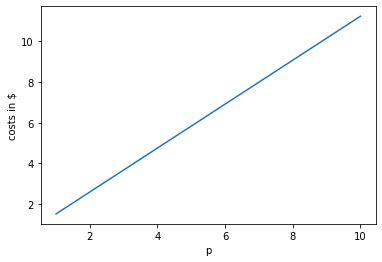

In [4]:
import  matplotlib.pyplot as plt
costs = []
for p in range(1,11):
    view = PlatformsViewController(qc[p-1])
    costs.append( view.get_cost_27(2, 1000) ) 
plt.plot(range(1,11), costs)
plt.xlabel('p')
plt.ylabel('costs in $')

In [5]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit import BasicAer
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt






def calc_qubo_value(M, v):
    quboSum = 0
    for i in range(0,len(v)):
        for j in range(0, len(v)):
            quboSum += v[i]*M[i][j]*v[j]
    return quboSum
def make_random_vector(nsize):
    v = [];
    for x in range(0, nsize):
        v.append(random.random())
    return v    

def random_index(nsize, vindex = []):
    if len(vindex) == nsize:
        return vindex
    index = random.randint(0,nsize-1)
#    index = rng.integers(0,nsize-1)
    for i in range(0,len(vindex)):
        if vindex[i] == index: 
            return random_index(nsize, vindex)
    vindex.append(index)
    return random_index(nsize, vindex)
def randomize_matrix(M, rv):
    newM = [([0]*len(M[0])) for i in range(len(M[0]))]
    for i in range(0, len(rv)):
        for j in range(0, len(rv)):
            if i > j:
                newM[i][j] = 0
            else:
                if rv[i] <= rv[j]:
                    newM[i][j] = M[rv[i]][rv[j]]
                else:
                    newM[i][j] = M[rv[j]][rv[i]]
    return newM
def split_matrix(M, size):
    M1 = []
    M2 = []
    if len(M) < size:
        return []
    for i in range(0, size):
        M1.append([])
        for j in range(0, size):
            M1[i].append(M[i][j])
    for i in range(size, len(M)):
        M2.append([])
        for j in range(size, len(M)):
            M2[i-size].append(M[i][j])
            
    return [M1, M2]

def create_vector_nodes(size):
    v = [i for i in range(size)]
    return v

def create_edges(M):
    edges = []
    for i in range(0, len(M)):
        for j in range (i + 1, len(M)):
            if M[i][j] != 0:
                edges.append((i,j))
    return edges        
def create_color_map(size, result = []):
    v = ['red' for i in range(size)]
    if len(result) == 0:
        return v
    for i in range(size):
        if result[i] == 1:
            v[i] = 'blue'
    return v

def create_graph(M):
    g = nx.Graph()
    
    g.add_nodes_from(create_vector_nodes(len(M)))
    g.add_edges_from(create_edges(M))
    return g

def draw_graph(g, result=[]):
    color_map = create_color_map(len(g.nodes), result)
    nx.draw(g, node_color=color_map, with_labels=True, alpha=0.8, node_size=500)

def slit_graph(M, size):
    listW = split_matrix(M, size)
    fig, axes = plt.subplots(nrows=1, ncols=len(listW),figsize=(12,5))
    for i in range(0, len(listW)):
        plt.subplot(1, 3, i+1)
        draw_graph(create_graph(listW[i]))


def create_qubo_problem(M):
    n = len(M);
    # Formulate the problem as a Docplex model
    model = Model()
    
    # Create n binary variables
    x = model.binary_var_list(n)

    # Define the objective function to be minimized
    model.minimize(calc_qubo_value(M, x))
    
    # Fix node 0 to be 1 to break the symmetry of the max-cut solution
    model.add(x[0] == 1)
    
    # Convert the Docplex model into a `QuadraticProgram` object
    problem = from_docplex_mp(model)
    return problem

class OptimizationResult:
    def __init__(self, result):
        self.result = result
    def x_to_str(self, x):
        strX = ''
        for i in range(0, len(x)):
            strX += str(x[i])
        return strX
    def get_probability_solution(self):
        probability_solution = {}
        for i in range(0, len(self.result.raw_samples)):
            probability_solution.update({self.x_to_str(self.result.raw_samples[i].x):self.result.raw_samples[i].probability})
        return probability_solution    
    def get_value_solution(self):
        value_solution = {}
        for i in range(0, len(self.result.raw_samples)):
            value_solution.update({self.x_to_str(self.result.raw_samples[i].x):self.result.raw_samples[i].fval})
        return value_solution    
        
    def get_solutions(self):
        rows = []
        for i in range(0, len(self.result.raw_samples)):
            rows.append(self.result.raw_samples[i].x)
        return rows



class AlgoritmQAOA:
    #constructor
    def __init__(self, M, reps=None, optimizer=None, q_i=None):
        self.problem = create_qubo_problem(M)
        self.W = M
        seed = 1234
        algorithm_globals.random_seed = seed
        if q_i == None:
            backend = BasicAer.get_backend('qasm_simulator') 
            q_i = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
        if optimizer == None:
            optimizer = SPSA(maxiter=250)
        if reps == None:
            reps = 1
        self.reps = reps    
        self.q_i = q_i
        self.change_optimizer(optimizer)
        self.initial_state = QuantumCircuit(len(self.problem.variables))
    #Rebuilding qaoa and circuit
    def set_qaoa(self):
        self.qaoa = QAOA(optimizer=self.optimizer, reps=self.reps, quantum_instance=self.q_i)
        self.algorithm = MinimumEigenOptimizer(self.qaoa)
        problem_ = self.algorithm._convert(self.problem, self.algorithm._converters)
        operator, offset = problem_.to_ising()
        self.ansatz = QAOAAnsatz(cost_operator=operator, reps=self.reps,  name = 'QAOA')
       

    #change classical optimizer for beta and gamma    
    def change_optimizer(self, optimizer):
        self.optimizer = optimizer
        self.set_qaoa()
    #set parametr p for QAOA
    def set_reps(self, reps = None):
        if reps != None:
            self.reps = reps
        self.set_qaoa()
    #get circuit QAOA
    def get_circuit(self, reps = None):
        sv_reps = self.reps;
        self.set_reps(reps)
        qc = self.ansatz
        self.set_reps(sv_reps)
        return qc
    #solve problem     
    def solve(self, reps = None):
        sv_reps = self.reps;
        self.set_reps(reps)
        self.result = OptimizationResult(self.algorithm.solve(self.problem))
        self.set_reps(sv_reps)
        return self.result

        
def plot_value(res):
    vr = dict(sorted(res.items()))

    pos = np.arange(len(vr.keys()))
    width = 0.5     # gives histogram aspect to the bar diagram

    ax = plt.axes()
    ax.set_xticks(pos + (width / 2))
    ax.set_xticklabels(vr.keys())
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=45, horizontalalignment='right')

    plt.bar(vr.keys(), vr.values(), width, color='b')
    plt.show()

def draw_graph_solution(alg):
    gr = create_graph(alg.W)
    s = alg.result.get_solutions()
    l = 5
    if l > len(s):
        l = len(s)
    fig, axes = plt.subplots(nrows=1, ncols=l,figsize=(20,7))
    for i in range(0, l):
        plt.subplot(1, l+1, i+1)
        plt.title(alg.result.x_to_str(s[i]))
        draw_graph(create_graph(gr), s[i])

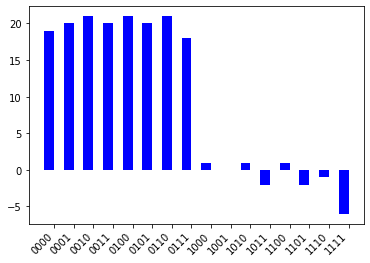

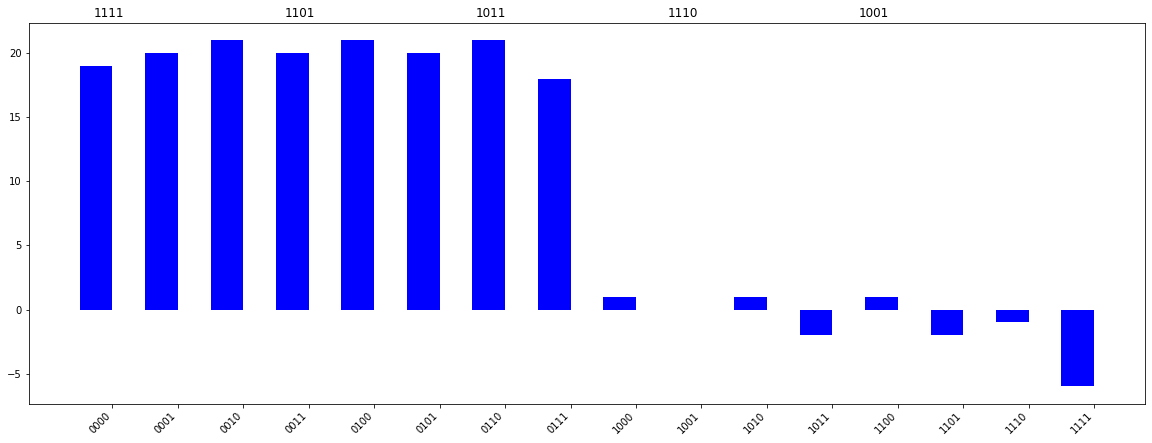

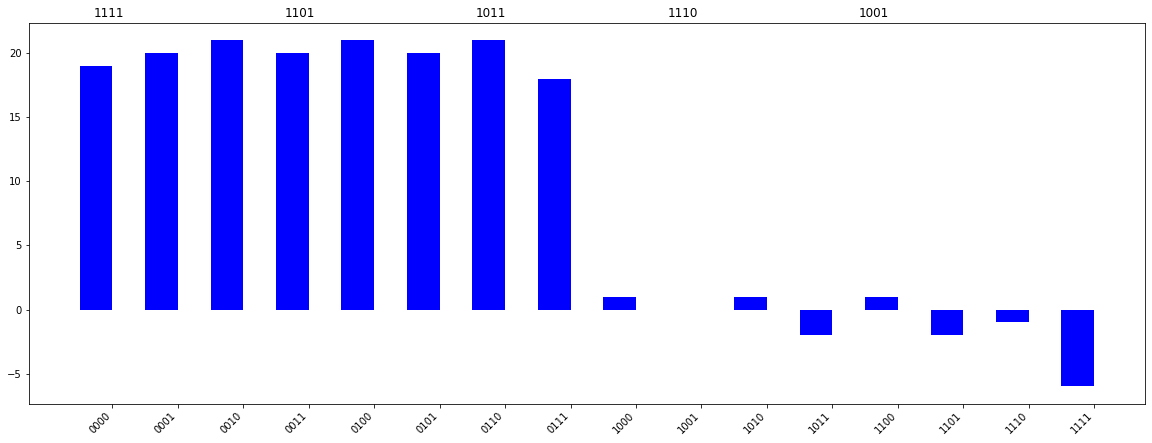

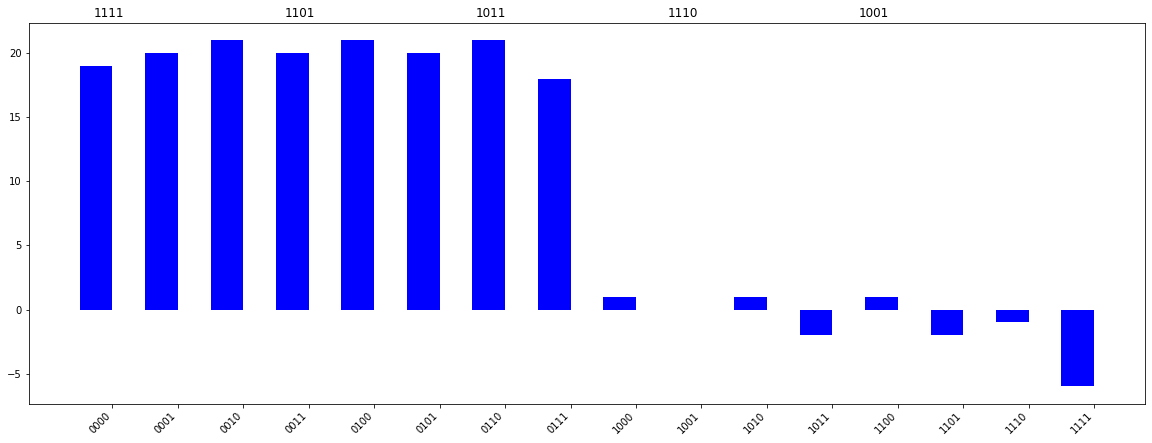

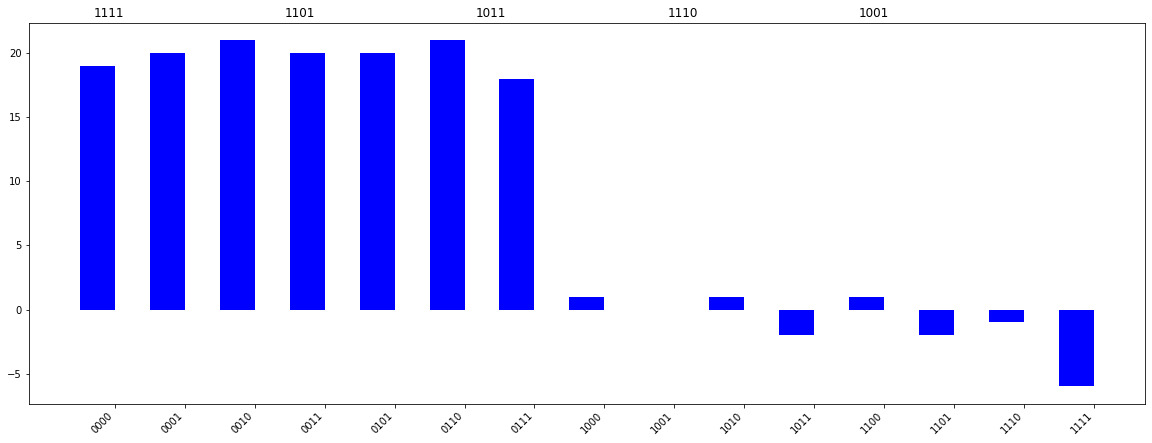

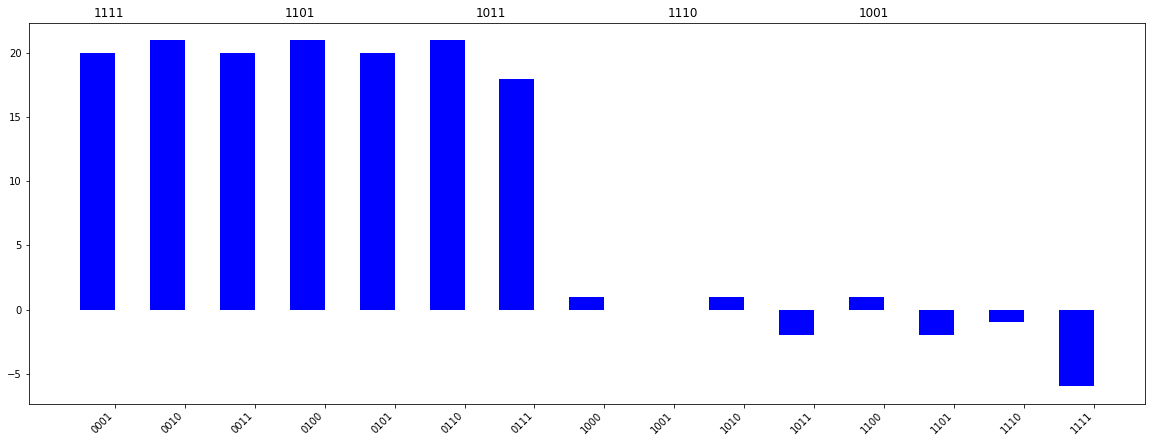

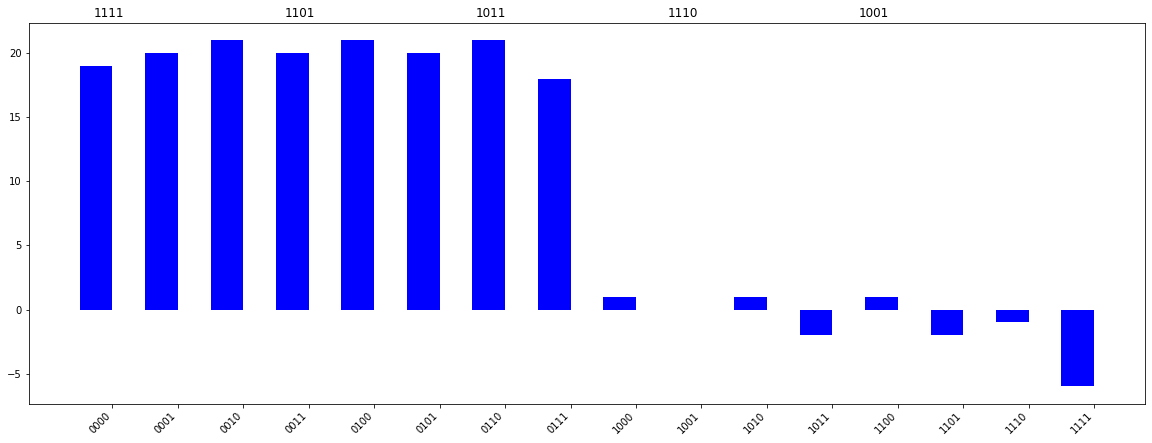

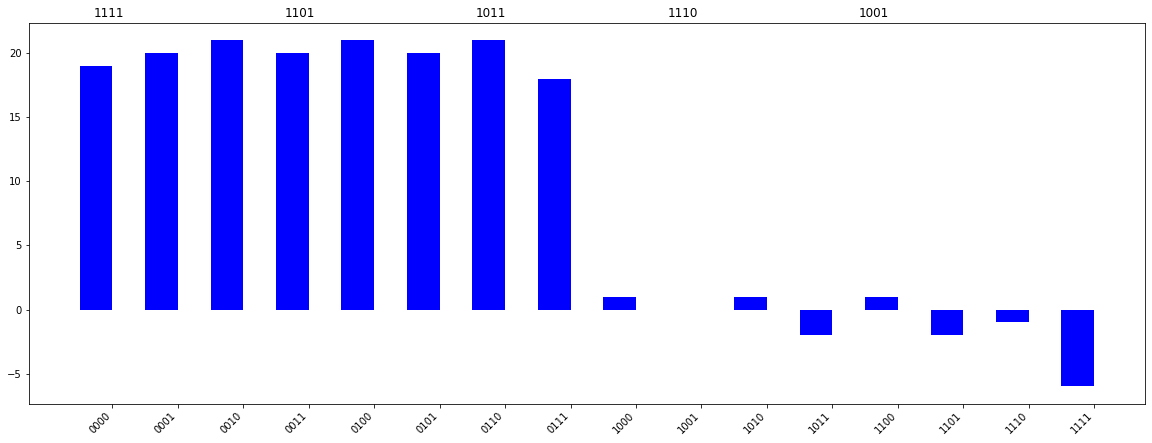

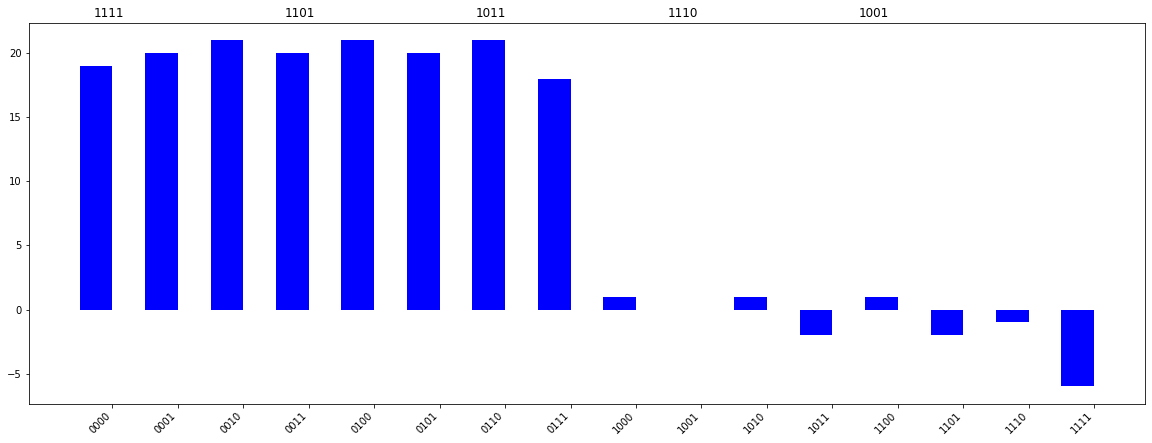

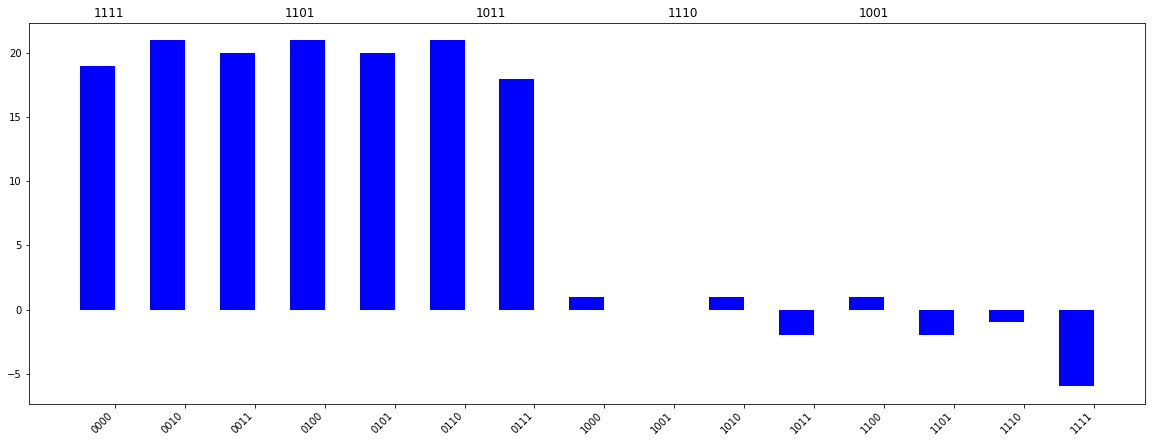

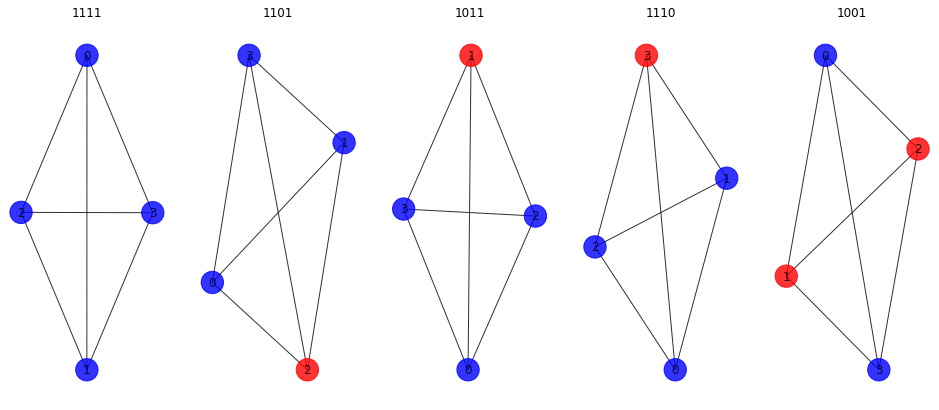

In [6]:
from qiskit.visualization import plot_histogram

for p in range(1,11):
    result = alg[p-2].solve()
    #r = alg[p-2].result.get_probability_solution()
    #plot_histogram(r)
    vr = alg[p-2].result.get_value_solution()
    plot_value(vr)
    draw_graph_solution(alg[p-2])

Finding the optimal solution

Rendering result

In this case the assignments of the graph that gives 4 edges between the two partitions: "0101" and "1010"  are optimal. They occure as first solutions not reached for any p, instead in every calcuation 1111 is estimated.


We can consider more complex example. 

There were various problem types that can be formulated a QUBO, [here](https://blog.xa0.de/post/List-of-QUBO-formulations/#fn:S20) and [here](https://or.stackexchange.com/questions/828/what-are-some-real-world-applications-of-qubo/978#978) you find a list of QUBO formulations of problems, QAOA is applicable on for solving it. 

Another QUBO usecase is **sensor position optimization** described [here](https://crowd-innovation.bmwgroup.com/servlet/hype/IMT?documentTableId=7025714350976893092&userAction=Browse&templateName=&documentId=740c3d47812c470b208a495d85f18206) 

To keep the considered matrix small, we will consider another use case from Fujitsu presented [here](https://www.youtube.com/watch?v=dA7Nbarm4UM). Reflectors and Lens with different tolerance limits are given and must together comply with the total tolerance.
Given five gears of each type, there are 5!= 120 possible combinations. This example consits of a graph with 10 nodes an 5 vertices

In [7]:

reflector_tol= [1.06, 0.99, 1.07, 1.05, 1.06]
lens_tol = [1.01, 0.99, 0.98, 0.99, 1.0]

#combined_tol is the average of both and neeed to be equal to total_tol

total_tol = 1.0
# an deviation on 0.025 is allowed

#unfinished

In [8]:
#